# Обучение нейронной сети

## Импорт библиотек

In [372]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

## Создание датасетов и разделение данных

In [373]:
from torch.utils.data import Dataset, DataLoader, random_split

In [374]:
class PermAppartmentDataset(Dataset):
    def __init__(self, filename):
        super().__init__()
        data = pd.read_csv(filename, sep=';')
        self.y = torch.from_numpy(data.price.values).to(dtype=torch.float32)
        self.x = torch.from_numpy(data.drop('price', axis=1).values).to(dtype=torch.float32)
        self.n = len(self.y)
        del data
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [375]:
dataset = PermAppartmentDataset('../final_data.csv')

In [376]:
dataset[0][0], dataset[0][1] 

(tensor([3.0000e+00, 6.1200e+01, 5.0000e+00, 1.0000e+00, 1.9720e+03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7961e+01, 5.6171e+01,
         2.0000e+01, 3.6000e+01, 4.0000e+00, 1.6000e+02, 6.4469e+03]),
 tensor(3200000.))

In [377]:
test_size = int(0.15 * len(dataset))
valid_size = int(0.15 * len(dataset))
train_size = len(dataset) - test_size - valid_size

In [378]:
test_set, valid_set, train_set = random_split(dataset, [test_size, valid_size, train_size])

In [379]:
print("Размер тестового множества: " + str(len(test_set)))

Размер тестового множества: 265


In [380]:
print("Размер валидационного множества: " + str(len(valid_set)))

Размер валидационного множества: 265


In [381]:
print("Размер тренировочного множества: " + str(len(train_set)))

Размер тренировочного множества: 1237


# Загрузчики данных

In [382]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=True)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Составление модели

In [427]:
def train_loop(n_epoch, loss, optimizer, train_dl, val_dl, train_size, valid_size, every_n_epoch_print=1000):
    global model
    for epoch in range(n_epoch):
        if epoch%every_n_epoch_print == 0:
            #   Считаем ошибку на тестовой выборке
            train_loss = 0
            val_loss = 0
            model.eval()
            with torch.no_grad():
                #   Считаем ошибку на обучающей выборке
                for i, (X, y) in enumerate(train_dl):
                    y_pred = model(X)
                    l = loss(y_pred, y.reshape(-1, 1))
                    train_loss += l.item() * len(y)
                #   Считаем ошибку на тестовой выборке
                for i, (X, y) in enumerate(val_dl):
                    y_pred = model(X)
                    l = loss(y_pred, y.reshape(-1, 1))
                    val_loss += l.item() * len(y)
            model.train()

            print(epoch, "/", n_epoch, " : ", 
                  " train loss = ", np.sqrt(train_loss / train_size),
                  " val loss = ", np.sqrt(val_loss / valid_size))

        # Бежим по пакетам (batches)
        for i, (X, y) in enumerate(train_dl):
            # Предсказание
            y_pred = model(X)
            l = loss(y_pred, y.reshape(-1, 1))
            # Расчёт градиентов
            l.backward()
            # Оптимизация
            optimizer.step()
            # Зануляем градиент
            optimizer.zero_grad()

In [428]:
def evaluate_on_test(loss, test_dl, test_size):
    global model
    predicts = []
    reals = []
    test_loss = 0
    model.eval()
    with torch.no_grad():
        #   Считаем ошибку на тестовой выборке
        for i, (X, y) in enumerate(test_dl):
            y_pred = model(X)
            for real, predict in zip(y.reshape(-1), y_pred.reshape(-1)):
                real_value = real.item()
                predict_value = predict.item()
                if abs(real_value-predict_value) < 1_000_000:
                    predicts.append(predict_value)
                    reals.append(real_value)
            l = loss(y_pred, y.reshape(-1, 1))
            test_loss += l.item() * len(y)
    model.train()

    print("test loss = ", np.sqrt(test_loss / test_size))
    plt.figure(figsize=(15, 16))
    plt.subplot(2, 1, 1)
    plt.plot([0, 20_000_000], [0, 20_000_000], c='r')
    plt.scatter(reals, predicts, alpha=0.7)
    plt.xlabel("Реальная цена", size=20)
    plt.ylabel("Предсказанная цена", size=20)
    plt.subplot(2, 1, 2)
    plt.plot(reals, '-ro', linewidth=2, label='реальные значения')
    plt.plot(predicts, '-go', linewidth=2, label='предсказания')
    plt.legend()

## Линейная регрессия c байесом и без регуляризации

In [429]:
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

In [436]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(41, 10, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1, bias=False)

    def forward(self, x):
        res = self.fc1(x)
        res = self.relu(res)
        res = self.fc2(res)
        return res

In [437]:
model = LinearRegression()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000000001, momentum=0.9, nesterov=True, weight_decay=0.1)

In [438]:
train_loop(
    n_epoch = 100001,
    every_n_epoch_print=1000,
    loss = loss, 
    optimizer = optimizer,
    train_dl = train_loader, 
    val_dl = valid_loader, 
    train_size = train_size, 
    valid_size = valid_size
)

0 / 100001  :   train loss =  4994891.646338699  val loss =  5007935.512059809
1000 / 100001  :   train loss =  4994570.454464201  val loss =  5007618.031711128
2000 / 100001  :   train loss =  4994570.416107564  val loss =  5007618.09532015
3000 / 100001  :   train loss =  4994570.4083853215  val loss =  5007618.121000811
4000 / 100001  :   train loss =  4994570.40490607  val loss =  5007618.139174818


KeyboardInterrupt: 

test loss =  1331759.2495865123


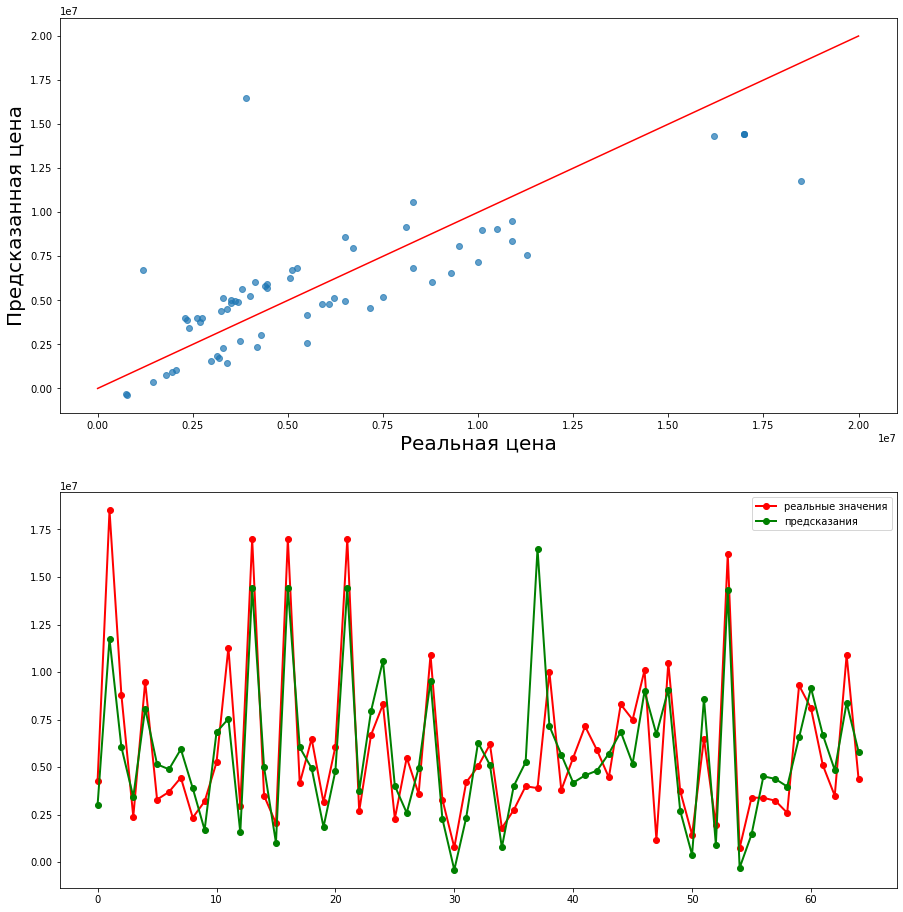

In [435]:
evaluate_on_test(
    loss = loss, 
    test_dl = test_loader, 
    test_size = test_size, 
)